# 在多个GPU上训练
:label:`sec_multi_gpu`

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型。我们甚至展示了深度学习框架如何在:numref:`sec_auto_para`中自动并行化计算和通信。我们在:numref:`sec_use_gpu`中还展示了如何使用`nvidia-smi`命令列出计算机上的所有可用GPU。
我们*没有*讨论的是如何实际并行化深度学习训练。
相反，我们顺便提到，会以某种方式将数据分割到多个设备上并使其工作。本节填补了这些细节，并展示了从头开始时如何并行训练网络。关于如何利用高级API中的功能的详细信息，请参见:numref:`sec_multi_gpu_concise`。
我们假设您熟悉像:numref:`sec_minibatch_sgd`中描述的那样小批量随机梯度下降算法。


## 问题划分

让我们从一个简单的计算机视觉问题和一个稍微过时的网络开始，例如，具有多层卷积、池化以及可能在最后有几个全连接层的网络。
也就是说，让我们从一个看起来非常类似于LeNet :cite:`LeCun.Bottou.Bengio.ea.1998`或AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`的网络开始。
给定多个GPU（如果它是台式服务器，则为2个；在AWS g4dn.12xlarge实例上为4个，在p3.16xlarge上为8个，在p2.16xlarge上为16个），我们希望以一种能够实现良好加速同时受益于简单且可重现的设计选择的方式分区训练。毕竟，多个GPU既增加了*内存*也增加了*计算*能力。简而言之，给定一个我们想要分类的小批量训练数据，我们有以下选择。

首先，我们可以在多个GPU之间划分网络。也就是说，每个GPU接收流入特定层的数据，处理若干后续层的数据，然后将数据发送到下一个GPU。
这使我们能够处理比单个GPU所能处理的更大的网络。
此外，
每块GPU的内存占用可以得到很好的控制（它是总网络占用的一部分）。

然而，层与层之间的接口（以及因此GPU之间的接口）需要紧密同步。这可能会很棘手，特别是当各层之间的计算工作负载不匹配时。对于大量的GPU，这个问题更加严重。
层与层之间的接口也需要大量的数据传输，
如激活值和梯度。
这可能会超出GPU总线的带宽。
此外，计算密集但顺序的操作不容易分区。例如，参见:citet:`Mirhoseini.Pham.Le.ea.2017`中的最佳努力。它仍然是一个难题，目前尚不清楚是否有可能在非平凡的问题上实现良好的（线性）扩展。除非框架或操作系统对链接多个GPU有极好的支持，否则我们不推荐这样做。


其次，我们可以逐层划分工作。例如，与其在单个GPU上计算64个通道，不如将问题划分为4个GPU，每个GPU生成16个通道的数据。
同样，对于全连接层，我们可以划分输出单元的数量。:numref:`fig_alexnet_original`（取自:citet:`Krizhevsky.Sutskever.Hinton.2012`）
说明了这种设计，其中使用此策略来处理当时内存占用非常小的GPU（2 GB）。
这允许在计算方面进行良好的扩展，前提是通道（或单元）数量不太小。
此外，
多个GPU可以处理越来越大的网络，因为可用内存是线性增长的。

![由于GPU内存有限，原始AlexNet设计中的模型并行。](../img/alexnet-original.svg)
:label:`fig_alexnet_original`

然而，
我们需要大量的同步或屏障操作，因为每一层都依赖于其他所有层的结果。
此外，需要传输的数据量可能比在GPU之间分配层时还要大。因此，由于带宽成本和复杂性，我们不推荐这种方法。

最后，我们可以在多个GPU之间划分数据。这样，所有GPU执行相同类型的工作，尽管是在不同的观测值上。每次小批量训练数据后，都会在GPU之间聚合梯度。
这是最简单的方法，可以应用于任何情况。
我们只需要在每次小批量之后同步。也就是说，非常希望在其他梯度参数仍在计算时就开始交换梯度参数。
此外，更多的GPU会导致更大的小批量大小，从而提高训练效率。
然而，增加更多GPU并不允许我们训练更大的模型。


![在多个GPU上的并行化。从左至右：原始问题、网络分区、逐层分区、数据并行。](../img/splitting.svg)
:label:`fig_splitting`


:numref:`fig_splitting`描绘了不同方式在多个GPU上的并行化比较。
总的来说，只要我们能够访问到具有足够大内存的GPU，数据并行是最方便的方式。另请参阅:cite:`Li.Andersen.Park.ea.2014`，了解分布式训练分区的详细描述。在深度学习早期，GPU内存曾是一个问题。到现在为止，除了最不寻常的情况外，这个问题已经得到了解决。接下来我们将关注数据并行。

## 数据并行

假设机器上有$k$个GPU。给定要训练的模型，每个GPU将独立维护一套完整的模型参数，尽管跨GPU的参数值是相同的并且是同步的。
例如，
:numref:`fig_data_parallel`展示了
当$k=2$时
使用数据并行的训练过程。


![使用两块GPU的数据并行计算小批量随机梯度下降。](../img/data-parallel.svg)
:label:`fig_data_parallel`

一般来说，训练过程如下：

* 在训练的任何迭代中，给定一个随机小批量，我们将批次中的样本分成$k$部分，并均匀分布在GPU上。
* 每个GPU根据分配给它的子集计算损失和模型参数的梯度。
* 将每个$k$ GPU的局部梯度聚合以获得当前小批量随机梯度。
* 将聚合梯度重新分发到每个GPU。
* 每个GPU使用这个小批量随机梯度更新其维护的完整模型参数集合。



请注意，在实践中，当在$k$个GPU上训练时，我们会将小批量大小增加$k$倍，这样每个GPU的工作量与仅在一个GPU上训练时相同。在16-GPU服务器上，这可以大大增加小批量大小，我们可能需要相应地增加学习率。
还需注意，:numref:`sec_batch_norm`中的批量归一化需要调整，例如，通过为每个GPU保持单独的批量归一化系数。
接下来我们将使用一个玩具网络来说明多GPU训练。

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## [**一个玩具网络**]

我们使用在:numref:`sec_lenet`中介绍的LeNet（稍作修改）。我们从零开始定义它，以详细说明参数交换和同步。

In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

## 数据同步

为了高效地进行多GPU训练，我们需要两个基本操作。
首先，我们需要有能力将参数列表[**分发到多个设备**]并附加梯度（`get_params`）。没有参数就无法在GPU上评估网络。
其次，我们需要能够在多个设备间对参数求和，即我们需要一个`allreduce`函数。

In [3]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

让我们通过将模型参数复制到一个GPU上来试一试。

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


由于我们还没有进行任何计算，所以相对于偏置参数的梯度仍然是零。
现在假设我们有一个分布在多个GPU上的向量。以下[**`allreduce`函数将所有向量相加并将结果广播回所有GPU**]。请注意，为了使这工作，我们需要将数据复制到累积结果的设备上。

In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

让我们通过在不同设备上创建具有不同值的向量并聚合它们来测试这一点。

In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## 数据分发

我们需要一个简单的实用函数来[**将小批量数据均匀分配到多个GPU上**]。例如，在两个GPU上，我们希望将一半的数据复制到任一GPU上。
由于这样更方便且更简洁，我们使用深度学习框架中的内置函数在一个$4 \times 5$矩阵上进行尝试。

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


为了以后重用，我们定义了一个`split_batch`函数，该函数可以同时分割数据和标签。

In [8]:
#@save
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## 训练

现在我们可以实现[**单个小批量的多GPU训练**]。其实施主要基于本节所述的数据并行方法。我们将使用刚刚讨论的辅助函数`allreduce`和`split_and_load`，以在多个GPU之间同步数据。请注意，我们不需要编写任何特定代码来实现并行性。由于计算图在一个小批量内的设备之间没有任何依赖关系，因此它会*自动*并行执行。

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # Backpropagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # Here, we use a full-size batch

现在，我们可以定义[**训练函数**]。它与前面章节中使用的略有不同：我们需要分配GPU并将所有模型参数复制到所有设备上。
显然，每个批次都使用`train_batch`函数处理以应对多GPU的情况。为了方便（以及代码的简洁性），我们在单个GPU上计算准确率，尽管这是*低效的*，因为其他GPU处于空闲状态。

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to `num_gpus` GPUs
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Evaluate the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

让我们看看这在[**单个GPU**]上的效果如何。
我们首先使用256的批量大小和0.2的学习率。

test acc: 0.83, 3.0 sec/epoch on [device(type='cuda', index=0)]


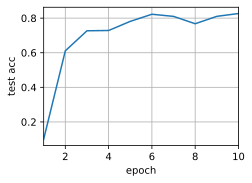

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

通过保持批量大小和学习率不变并[**将GPU数量增加到2**]，我们可以看到测试准确率与之前的实验相比大致保持不变。
在优化算法方面，它们是相同的。不幸的是，在这里没有获得有意义的速度提升：模型实在太小了；此外，我们只有一个小型数据集，在这种情况下，我们稍微不那么复杂的多GPU训练实现方式遭受了显著的Python开销。在后续的学习中，我们将遇到更复杂的模型和更精细的并行化方法。
让我们看看对于Fashion-MNIST会发生什么。

test acc: 0.84, 2.8 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


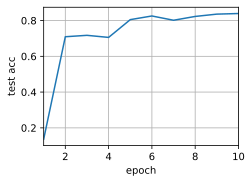

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 摘要

* 有多种方法可以将深度网络训练分布在多个GPU上。我们可以在层之间、跨层或跨数据进行分割。前两种方法需要精心编排的数据传输。数据并行是最简单的策略。
* 数据并行训练非常直接。然而，为了提高效率，它会增加有效的迷你批处理大小。
* 在数据并行中，数据被分散到多个GPU上，每个GPU执行自己的前向和后向操作，随后梯度被聚合，并且结果被广播回各个GPU。
* 对于较大的迷你批处理，我们可以使用稍微增加的学习率。

## 练习

1. 当在$k$个GPU上进行训练时，将迷你批处理大小从$b$变更为$k \cdot b$，即按GPU数量放大。
1. 比较不同学习率下的准确率。它如何随GPU数量变化？
1. 实现一个更高效的`allreduce`函数来聚合不同GPU上的不同参数？为什么它更高效？
1. 实现多GPU测试准确率计算。

[讨论](https://discuss.d2l.ai/t/1669)